In [54]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
! pip install optuna
import optuna
!pip install fasttext
import fasttext

In [55]:
model_name = "bert-base-uncased"

# task 1 , 2 , 3 (load)

In [56]:
with open('bert_vectors_train_'+model_name+'.pkl', 'rb') as f:
    encode_train_vectors, train_labels = pickle.load(f)

with open('bert_vectors_val_'+model_name+'.pkl', 'rb') as f:
    encode_val_vectors, val_labels = pickle.load(f)


In [57]:
print(train_labels.values.shape , encode_train_vectors.shape)
# train_labels = train_labels.values.flatten()
# val_labels  = val_labels.values.flatten()
input_dim_x = encode_train_vectors.shape[1]
print(input_dim_x)

(8480,) (8480, 768)
768


# Task 4

In [58]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        # Convert sparse matrix to dense tensor
        self.x = torch.tensor(X.reshape(-1, 1, 768), dtype=torch.float32)
        self.y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # Add an extra dimension to represent channels (1 in this case)
        x_sample = self.x[idx]   # .unsqueeze(0)
        return x_sample, self.y[idx]

In [59]:
train_dataset = CustomDataset(encode_train_vectors, train_labels)
eval_dataset = CustomDataset(encode_val_vectors, val_labels)

In [60]:
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
eval_dataloader = DataLoader(eval_dataset, batch_size = 32, shuffle = False)

In [61]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([32, 1, 768]) torch.Size([32])


## Basic Network

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [63]:
import torch.nn as nn

class ConvolutionalNeuralNetwork0(nn.Module):
    def __init__(self, input_dim , input_channel = 1, num_classes=2):
        super(ConvolutionalNeuralNetwork0, self).__init__()

        self.conv1 = nn.Conv1d(in_channels= input_channel, out_channels=128, kernel_size=5)
        input_dim = self.calculate_conv_output_size(input_dim, 5, 1, 0)
        input_dim = self.calculate_pool_output_size(input_dim, 2)
        self.bn1 = nn.BatchNorm1d(128)

        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3)
        input_dim = self.calculate_conv_output_size(input_dim, 3, 1, 0)
        input_dim = self.calculate_pool_output_size(input_dim, 2)
        self.bn2 = nn.BatchNorm1d(256)

        self.conv3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3)
        input_dim = self.calculate_conv_output_size(input_dim, 3, 1, 0)
        input_dim = self.calculate_pool_output_size(input_dim, 2)
        self.bn3 = nn.BatchNorm1d(256)

        self.fc1 = nn.Linear(256 * input_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)

    def calculate_conv_output_size(self, input_size, kernel_size, stride, padding):
        return int(((input_size - kernel_size + 2 * padding) / stride) + 1)

    def calculate_pool_output_size(self, input_size, pool_size):
        return int((input_size  / pool_size))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [64]:
import torch
network = ConvolutionalNeuralNetwork0(input_dim = input_dim_x).to(device)

In [65]:
from torchsummary import summary
# Assuming your input data size is (970, 100)
input_size = (1, input_dim_x)  # (channels, width)

# Print the model summary
summary(network, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 128, 764]             768
       BatchNorm1d-2             [-1, 128, 764]             256
              ReLU-3             [-1, 128, 764]               0
         MaxPool1d-4             [-1, 128, 382]               0
            Conv1d-5             [-1, 256, 380]          98,560
       BatchNorm1d-6             [-1, 256, 380]             512
              ReLU-7             [-1, 256, 380]               0
         MaxPool1d-8             [-1, 256, 190]               0
            Conv1d-9             [-1, 256, 188]         196,864
      BatchNorm1d-10             [-1, 256, 188]             512
             ReLU-11             [-1, 256, 188]               0
        MaxPool1d-12              [-1, 256, 94]               0
           Linear-13                  [-1, 128]       3,080,320
             ReLU-14                  [

In [66]:
batch_x, batch_y = next(iter(train_dataloader))
print(batch_x.shape, batch_y.shape)

torch.Size([32, 1, 768]) torch.Size([32])


## Basic Training Loop

In [67]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(network.parameters(), lr = 0.001)
epochs = 10

In [68]:
train_epoch_loss = []
eval_epoch_loss = []

In [69]:
for epoch in tqdm(range(epochs)):
    curr_loss = 0
    total = 0
    for train_x, train_y in train_dataloader:

        train_x = train_x.to(device)
        train_y = train_y.to(device)
        optim.zero_grad()

        y_pred = network(train_x)
        loss = criterion(y_pred, train_y)

        loss.backward()
        optim.step()

        curr_loss += loss.item()
        total += len(train_y)
    train_epoch_loss.append(curr_loss / total)

    curr_loss = 0
    total = 0
    for eval_x, eval_y in eval_dataloader:
        eval_x = eval_x.to(device)
        eval_y = eval_y.to(device)
        optim.zero_grad()

        with torch.no_grad():
            y_pred = network(eval_x)

        loss = criterion(y_pred, eval_y)

        curr_loss += loss.item()
        total += len(train_y)
    eval_epoch_loss.append(curr_loss / total)


100%|██████████| 10/10 [00:32<00:00,  3.27s/it]


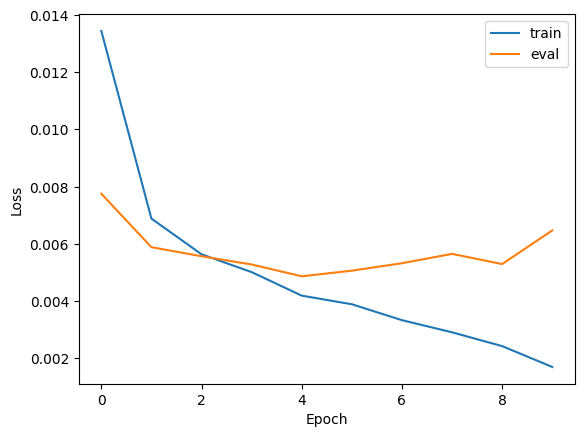

In [70]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_epoch_loss, label='train')
plt.plot(range(epochs), eval_epoch_loss, label='eval')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [71]:
correct = 0
total = 0
for x, y in eval_dataloader:
    x = x.to(device)
    with torch.no_grad():
        yp = network(x)
    yp = torch.argmax(yp.cpu(), dim = 1)
    correct += (yp == y).sum()
    total += len(y)
prev_eval_acc = correct / total
print(f"Accuracy on Eval Data {(prev_eval_acc * 100):.2f}")

Accuracy on Eval Data 94.06


In [72]:
prev_model = network

## now hyperparameter optimization

In [73]:
!pip install torchmetrics
from torchmetrics import Accuracy

In [74]:
import torch.nn.init as init  # Import the init module from PyTorch

class ConvolutionalNeuralNetwork2(nn.Module):
    def __init__(self, input_dim, in_channels, output_dim, n_layers, n_units, dropout_prob, activation, optimizer_name,weight_init_method, learning_rate, cnn_kernel, cnn_stride, cnn_padding, cnn_channel):
        super(ConvolutionalNeuralNetwork2, self).__init__()
        layers = []

        # self.conv1 = nn.Conv1d(in_channels=d, out_channels=128, kernel_size=5)
        # self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3)

        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=cnn_channel, kernel_size=cnn_kernel, stride=cnn_stride, padding=cnn_padding)
        input_dim = self.calculate_conv_output_size(input_dim, cnn_kernel, cnn_stride, cnn_padding)
        input_dim = self.calculate_pool_output_size(input_dim, 2)

        self.conv2 = nn.Conv1d(in_channels=cnn_channel, out_channels=cnn_channel, kernel_size=cnn_kernel, stride=cnn_stride, padding=cnn_padding)
        input_dim = self.calculate_conv_output_size(input_dim, cnn_kernel, cnn_stride, cnn_padding)
        input_dim = self.calculate_pool_output_size(input_dim, 2)

        self.fc1 = nn.Linear(cnn_channel * input_dim, 128)

        self.activation = activation
        self.pool = nn.MaxPool1d(2)
        self.bn = nn.BatchNorm1d(cnn_channel)

        in_features = 128
        for i in range(n_layers):
            layers.append(nn.Linear(in_features, n_units))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_prob))
            in_features = n_units
        layers.append(nn.Linear(in_features, output_dim))
        self.layers = nn.Sequential(*layers)
        # Initialize optimizer and learning rate scheduler
        self.optimizer_name = optimizer_name
        self.optimizer = self._get_optimizer(optimizer_name, learning_rate)
        # self.apply_weight_init(weight_init_method)

    def _get_optimizer(self, optimizer_name, learning_rate):
        if optimizer_name == 'Adam':
            return torch.optim.Adam(self.parameters(), lr=learning_rate)
        elif optimizer_name == 'SGD':
            return torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        elif optimizer_name == 'RMSprop':
            return torch.optim.RMSprop(self.parameters(), lr=learning_rate)
        else:
            raise ValueError(f'Invalid optimizer name: {optimizer_name}')

    def apply_weight_init(self, weight_init_method):
        if weight_init_method == 'uniform':
            init_func = init.uniform_
        elif weight_init_method == 'normal':
            init_func = init.normal_
        elif weight_init_method == 'xavier':
            init_func = init.xavier_uniform_
        else:
            raise ValueError(f'Invalid weight initialization method: {weight_init_method}')
        # Apply weight initialization to each linear layer
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init_func(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def calculate_conv_output_size(self, input_size, kernel_size, stride, padding):
        return int(((input_size - kernel_size + 2 * padding) / stride) + 1)

    def calculate_pool_output_size(self, input_size, pool_size):
        return int((input_size  / pool_size))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.activation(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn(x)
        x = self.activation(x)
        x = self.pool(x)

        # Flatten the output before the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return self.layers(x)

In [75]:
def train_model(model, criterion, optimizer, dataloader, device):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Calculate accuracy
        y_pred = torch.argmax(outputs, dim = 1)
        correct_predictions += (y_pred == targets).sum().item()
        total_samples += len(targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    accuracy = correct_predictions / total_samples
    total_loss /= total_samples
    return total_loss, accuracy

In [76]:
def evaluate_model(network, criterion, eval_dataloader, device):
    network.eval()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for eval_x, eval_y in eval_dataloader:
            eval_x = eval_x.to(device)
            eval_y = eval_y.to(device)

            y_pred = network(eval_x)
            loss = criterion(y_pred, eval_y)

            total_loss += loss.item()

            # Calculate accuracy
            y_pred = torch.argmax(y_pred, dim = 1)
            correct_predictions += (y_pred == eval_y).sum().item()
            total_samples += len(eval_y)

    total_loss /= total_samples
    accuracy = correct_predictions / total_samples

    return total_loss, accuracy

In [77]:
import optuna
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.nn.init import xavier_uniform_, kaiming_normal_
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.nn import LeakyReLU, PReLU
from torch.utils.data import DataLoader
from torch.nn import L1Loss, MSELoss

def objective(trial):
    # Define hyperparameters to be optimized
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    n_layers = trial.suggest_int("n_layers", 1, 2)
    n_units = trial.suggest_int("n_units", 16, 128)
    dropout_prob = trial.suggest_float("dropout_prob", 0.0, 0.5)
    activation = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "PReLU"])
    weight_init_method = trial.suggest_categorical("weight_init_method", ["uniform", "normal", "xavier"])
    optimizer_choice = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    # lr_schedule = trial.suggest_categorical("lr_schedule", ["step_lr", "exp_lr"])
    use_early_stopping = trial.suggest_categorical("use_early_stopping", [True, False])
    patience = trial.suggest_int("patience", 5, 10)
    # gradient_accumulation_steps = trial.suggest_int("gradient_accumulation_steps", 1, 5)
    # regularization_strength = trial.suggest_float("regularization_strength", 0.0, 0.1)
    epochs = trial.suggest_int("epochs", 10, 25)

    #for CNN
    cnn_kernel = 2 * (trial.suggest_int("cnn_kernel", 1, 3)) + 1  # to get odd number using 2*x+1
    max_stride_pad = (cnn_kernel - 1)/2
    cnn_stride = trial.suggest_int("cnn_stride", 1, max_stride_pad)
    cnn_padding = trial.suggest_categorical("cnn_padding", [0, 3])
    cnn_channel = trial.suggest_categorical("cnn_channel", [32, 64, 128])

    # Wrap activation functions inside nn.Module subclass
    if activation == "ReLU":
        activation =nn.ReLU()
    elif activation == "LeakyReLU":
        activation =nn.LeakyReLU()
    elif activation == "PReLU":
        activation =nn.PReLU()
    else:
        raise ValueError(f'Invalid activation method: {activation}')

    # Create an instance of your Network
    network = ConvolutionalNeuralNetwork2(input_dim = input_dim_x, in_channels=1, output_dim=2, n_layers=n_layers,
                            n_units=n_units, dropout_prob=dropout_prob, activation=activation,
                            optimizer_name=optimizer_choice,weight_init_method=weight_init_method,
                            learning_rate = learning_rate, cnn_kernel = cnn_kernel, cnn_stride = cnn_stride,
                            cnn_padding = cnn_padding, cnn_channel = cnn_channel)

    optimizer = network.optimizer

    # input_size = (100, 970)  # (channels, width)

    # # Print the model summary
    # summary(network, input_size=input_size)

    # Move the model to the appropriate device
    network.to(device)
    best_eval_loss = float('inf')
    no_improvement = 0

    # Define DataLoader instances
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
    # test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    for epoch in tqdm(range(epochs), desc="Epochs"):
        train_loss , train_acc = train_model(network, criterion, optimizer, train_dataloader, device)
        eval_loss, eval_acc = evaluate_model(network, criterion, eval_dataloader, device)

        # Report the validation loss to Optuna for optimization
        trial.report(eval_loss, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Early stopping
        if use_early_stopping:
            if eval_loss < best_eval_loss:
                best_val_loss = eval_loss
                no_improvement = 0
            else:
                no_improvement += 1
                if no_improvement >= patience:
                    break

    print(f"Training acc = {train_acc} , Val acc = {eval_acc}")
    return eval_acc  # eval_loss


In [78]:
# Create Optuna study and run optimization
study = optuna.create_study(direction="maximize")  # or "minimize" for a loss
study.optimize(objective, n_trials=30, timeout=5000)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-13 18:47:44,295] A new study created in memory with name: no-name-7b499153-8ba0-4608-a880-e76fb1db502f
Epochs: 100%|██████████| 18/18 [00:30<00:00,  1.70s/it]
[I 2024-03-13 18:48:14,951] Trial 0 finished with value: 0.9047169811320754 and parameters: {'learning_rate': 0.0007407862331029347, 'batch_size': 64, 'n_layers': 2, 'n_units': 104, 'dropout_prob': 0.3025121029857046, 'activation': 'LeakyReLU', 'weight_init_method': 'xavier', 'optimizer': 'RMSprop', 'use_early_stopping': False, 'patience': 10, 'epochs': 18, 'cnn_kernel': 1, 'cnn_stride': 1, 'cnn_padding': 0, 'cnn_channel': 128}. Best is trial 0 with value: 0.9047169811320754.


Training acc = 0.9550707547169811 , Val acc = 0.9047169811320754


Epochs: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s]
[I 2024-03-13 18:48:28,923] Trial 1 finished with value: 0.9311320754716981 and parameters: {'learning_rate': 1.5953727155913714e-05, 'batch_size': 64, 'n_layers': 2, 'n_units': 111, 'dropout_prob': 0.17091617950148918, 'activation': 'PReLU', 'weight_init_method': 'xavier', 'optimizer': 'Adam', 'use_early_stopping': True, 'patience': 9, 'epochs': 16, 'cnn_kernel': 3, 'cnn_stride': 1, 'cnn_padding': 3, 'cnn_channel': 64}. Best is trial 1 with value: 0.9311320754716981.


Training acc = 0.9550707547169811 , Val acc = 0.9311320754716981


Epochs: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s]
[I 2024-03-13 18:48:36,951] Trial 2 finished with value: 0.5 and parameters: {'learning_rate': 0.021438908631092452, 'batch_size': 64, 'n_layers': 1, 'n_units': 126, 'dropout_prob': 0.3281284058455737, 'activation': 'LeakyReLU', 'weight_init_method': 'uniform', 'optimizer': 'RMSprop', 'use_early_stopping': True, 'patience': 9, 'epochs': 15, 'cnn_kernel': 3, 'cnn_stride': 2, 'cnn_padding': 3, 'cnn_channel': 64}. Best is trial 1 with value: 0.9311320754716981.


Training acc = 0.625 , Val acc = 0.5


Epochs: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]
[I 2024-03-13 18:48:51,565] Trial 3 finished with value: 0.6754716981132075 and parameters: {'learning_rate': 0.0016831388334171548, 'batch_size': 32, 'n_layers': 1, 'n_units': 124, 'dropout_prob': 0.4120119659898079, 'activation': 'ReLU', 'weight_init_method': 'uniform', 'optimizer': 'Adam', 'use_early_stopping': False, 'patience': 7, 'epochs': 16, 'cnn_kernel': 3, 'cnn_stride': 3, 'cnn_padding': 3, 'cnn_channel': 32}. Best is trial 1 with value: 0.9311320754716981.


Training acc = 0.9786556603773585 , Val acc = 0.6754716981132075


Epochs: 100%|██████████| 17/17 [00:09<00:00,  1.70it/s]
[I 2024-03-13 18:49:01,589] Trial 4 finished with value: 0.5009433962264151 and parameters: {'learning_rate': 0.017341998053913604, 'batch_size': 128, 'n_layers': 1, 'n_units': 84, 'dropout_prob': 0.25880356500719304, 'activation': 'PReLU', 'weight_init_method': 'normal', 'optimizer': 'SGD', 'use_early_stopping': False, 'patience': 7, 'epochs': 17, 'cnn_kernel': 1, 'cnn_stride': 1, 'cnn_padding': 0, 'cnn_channel': 64}. Best is trial 1 with value: 0.9311320754716981.


Training acc = 0.96875 , Val acc = 0.5009433962264151


Epochs: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]
[I 2024-03-13 18:49:11,850] Trial 5 finished with value: 0.8584905660377359 and parameters: {'learning_rate': 7.159613476593695e-05, 'batch_size': 32, 'n_layers': 2, 'n_units': 89, 'dropout_prob': 0.15949319662872802, 'activation': 'ReLU', 'weight_init_method': 'xavier', 'optimizer': 'SGD', 'use_early_stopping': False, 'patience': 10, 'epochs': 10, 'cnn_kernel': 2, 'cnn_stride': 2, 'cnn_padding': 3, 'cnn_channel': 128}. Best is trial 1 with value: 0.9311320754716981.


Training acc = 0.9002358490566038 , Val acc = 0.8584905660377359


Epochs: 100%|██████████| 17/17 [00:19<00:00,  1.14s/it]
[I 2024-03-13 18:49:31,339] Trial 6 finished with value: 0.5 and parameters: {'learning_rate': 0.006080319545380235, 'batch_size': 32, 'n_layers': 2, 'n_units': 82, 'dropout_prob': 0.1018918376690538, 'activation': 'ReLU', 'weight_init_method': 'normal', 'optimizer': 'RMSprop', 'use_early_stopping': True, 'patience': 7, 'epochs': 17, 'cnn_kernel': 2, 'cnn_stride': 1, 'cnn_padding': 3, 'cnn_channel': 64}. Best is trial 1 with value: 0.9311320754716981.


Training acc = 0.9463443396226415 , Val acc = 0.5


Epochs: 100%|██████████| 19/19 [00:24<00:00,  1.29s/it]
[I 2024-03-13 18:49:55,833] Trial 7 finished with value: 0.8160377358490566 and parameters: {'learning_rate': 0.00010582783419932988, 'batch_size': 64, 'n_layers': 1, 'n_units': 40, 'dropout_prob': 0.20341296491319466, 'activation': 'ReLU', 'weight_init_method': 'xavier', 'optimizer': 'RMSprop', 'use_early_stopping': True, 'patience': 8, 'epochs': 19, 'cnn_kernel': 1, 'cnn_stride': 1, 'cnn_padding': 0, 'cnn_channel': 128}. Best is trial 1 with value: 0.9311320754716981.


Training acc = 0.9673349056603774 , Val acc = 0.8160377358490566


Epochs: 100%|██████████| 21/21 [00:21<00:00,  1.01s/it]
[I 2024-03-13 18:50:17,129] Trial 8 finished with value: 0.5 and parameters: {'learning_rate': 0.009551923246425462, 'batch_size': 32, 'n_layers': 2, 'n_units': 61, 'dropout_prob': 0.14231797826413406, 'activation': 'ReLU', 'weight_init_method': 'normal', 'optimizer': 'Adam', 'use_early_stopping': True, 'patience': 5, 'epochs': 21, 'cnn_kernel': 2, 'cnn_stride': 1, 'cnn_padding': 3, 'cnn_channel': 32}. Best is trial 1 with value: 0.9311320754716981.


Training acc = 0.5159198113207547 , Val acc = 0.5


Epochs: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]
[I 2024-03-13 18:50:28,237] Trial 9 finished with value: 0.8490566037735849 and parameters: {'learning_rate': 0.008302827756975776, 'batch_size': 32, 'n_layers': 2, 'n_units': 58, 'dropout_prob': 0.49280115817442416, 'activation': 'ReLU', 'weight_init_method': 'normal', 'optimizer': 'SGD', 'use_early_stopping': True, 'patience': 10, 'epochs': 12, 'cnn_kernel': 2, 'cnn_stride': 2, 'cnn_padding': 0, 'cnn_channel': 32}. Best is trial 1 with value: 0.9311320754716981.


Training acc = 0.9549528301886793 , Val acc = 0.8490566037735849


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]
[I 2024-03-13 18:50:28,724] Trial 10 pruned. 
Epochs: 100%|██████████| 21/21 [00:28<00:00,  1.34s/it]
[I 2024-03-13 18:50:56,859] Trial 11 finished with value: 0.8632075471698113 and parameters: {'learning_rate': 0.0003136486197128004, 'batch_size': 64, 'n_layers': 2, 'n_units': 104, 'dropout_prob': 0.29945558122787697, 'activation': 'LeakyReLU', 'weight_init_method': 'xavier', 'optimizer': 'Adam', 'use_early_stopping': False, 'patience': 9, 'epochs': 21, 'cnn_kernel': 1, 'cnn_stride': 1, 'cnn_padding': 0, 'cnn_channel': 128}. Best is trial 1 with value: 0.9311320754716981.


Training acc = 0.9864386792452831 , Val acc = 0.8632075471698113


Epochs: 100%|██████████| 14/14 [00:19<00:00,  1.36s/it]
[I 2024-03-13 18:51:16,051] Trial 12 finished with value: 0.5 and parameters: {'learning_rate': 0.08548631741925701, 'batch_size': 64, 'n_layers': 2, 'n_units': 107, 'dropout_prob': 0.352740142924042, 'activation': 'PReLU', 'weight_init_method': 'xavier', 'optimizer': 'RMSprop', 'use_early_stopping': False, 'patience': 9, 'epochs': 14, 'cnn_kernel': 1, 'cnn_stride': 1, 'cnn_padding': 0, 'cnn_channel': 128}. Best is trial 1 with value: 0.9311320754716981.


Training acc = 0.7795990566037736 , Val acc = 0.5


Epochs:   0%|          | 0/19 [00:00<?, ?it/s]
[I 2024-03-13 18:51:16,824] Trial 13 pruned. 
Epochs:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2024-03-13 18:51:17,766] Trial 14 pruned. 
Epochs:   0%|          | 0/23 [00:00<?, ?it/s]
[I 2024-03-13 18:51:18,494] Trial 15 pruned. 
Epochs:   0%|          | 0/20 [00:01<?, ?it/s]
[I 2024-03-13 18:51:19,928] Trial 16 pruned. 
Epochs: 100%|██████████| 18/18 [00:26<00:00,  1.47s/it]
[I 2024-03-13 18:51:46,397] Trial 17 finished with value: 0.5 and parameters: {'learning_rate': 0.0005636284235582872, 'batch_size': 64, 'n_layers': 1, 'n_units': 93, 'dropout_prob': 0.2064363120247653, 'activation': 'LeakyReLU', 'weight_init_method': 'xavier', 'optimizer': 'RMSprop', 'use_early_stopping': False, 'patience': 8, 'epochs': 18, 'cnn_kernel': 2, 'cnn_stride': 1, 'cnn_padding': 0, 'cnn_channel': 128}. Best is trial 1 with value: 0.9311320754716981.


Training acc = 0.9551886792452831 , Val acc = 0.5


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]
[I 2024-03-13 18:51:47,157] Trial 18 pruned. 
Epochs:   0%|          | 0/11 [00:00<?, ?it/s]
[I 2024-03-13 18:51:47,920] Trial 19 pruned. 
Epochs: 100%|██████████| 23/23 [00:31<00:00,  1.37s/it]
[I 2024-03-13 18:52:19,417] Trial 20 finished with value: 0.5 and parameters: {'learning_rate': 0.09920258351851043, 'batch_size': 128, 'n_layers': 1, 'n_units': 113, 'dropout_prob': 0.15532285386935774, 'activation': 'PReLU', 'weight_init_method': 'xavier', 'optimizer': 'RMSprop', 'use_early_stopping': True, 'patience': 10, 'epochs': 23, 'cnn_kernel': 2, 'cnn_stride': 1, 'cnn_padding': 0, 'cnn_channel': 128}. Best is trial 1 with value: 0.9311320754716981.


Training acc = 0.7825471698113208 , Val acc = 0.5


Epochs:   0%|          | 0/21 [00:01<?, ?it/s]
[I 2024-03-13 18:52:20,820] Trial 21 pruned. 
Epochs:   0%|          | 0/23 [00:01<?, ?it/s]
[I 2024-03-13 18:52:22,225] Trial 22 pruned. 
Epochs:   0%|          | 0/18 [00:01<?, ?it/s]
[I 2024-03-13 18:52:23,623] Trial 23 pruned. 
Epochs:   0%|          | 0/21 [00:01<?, ?it/s]
[I 2024-03-13 18:52:25,027] Trial 24 pruned. 
Epochs: 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]
[I 2024-03-13 18:52:36,658] Trial 25 finished with value: 0.5150943396226415 and parameters: {'learning_rate': 0.00011641045786311003, 'batch_size': 64, 'n_layers': 2, 'n_units': 93, 'dropout_prob': 0.31456035869076365, 'activation': 'LeakyReLU', 'weight_init_method': 'xavier', 'optimizer': 'Adam', 'use_early_stopping': False, 'patience': 9, 'epochs': 16, 'cnn_kernel': 1, 'cnn_stride': 1, 'cnn_padding': 0, 'cnn_channel': 64}. Best is trial 1 with value: 0.9311320754716981.


Training acc = 0.9785377358490566 , Val acc = 0.5150943396226415


Epochs:   0%|          | 0/19 [00:01<?, ?it/s]
[I 2024-03-13 18:52:38,240] Trial 26 pruned. 
Epochs:   0%|          | 0/22 [00:01<?, ?it/s]
[I 2024-03-13 18:52:39,884] Trial 27 pruned. 
Epochs:   0%|          | 0/25 [00:00<?, ?it/s]
[I 2024-03-13 18:52:40,553] Trial 28 pruned. 
Epochs: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]
[I 2024-03-13 18:52:48,469] Trial 29 finished with value: 0.5 and parameters: {'learning_rate': 0.0034140288498136525, 'batch_size': 64, 'n_layers': 1, 'n_units': 123, 'dropout_prob': 0.342634719931772, 'activation': 'LeakyReLU', 'weight_init_method': 'normal', 'optimizer': 'SGD', 'use_early_stopping': True, 'patience': 9, 'epochs': 15, 'cnn_kernel': 3, 'cnn_stride': 2, 'cnn_padding': 3, 'cnn_channel': 32}. Best is trial 1 with value: 0.9311320754716981.


Training acc = 0.9693396226415094 , Val acc = 0.5
Best trial:
  Value:  0.9311320754716981
  Params: 
    learning_rate: 1.5953727155913714e-05
    batch_size: 64
    n_layers: 2
    n_units: 111
    dropout_prob: 0.17091617950148918
    activation: PReLU
    weight_init_method: xavier
    optimizer: Adam
    use_early_stopping: True
    patience: 9
    epochs: 16
    cnn_kernel: 3
    cnn_stride: 1
    cnn_padding: 3
    cnn_channel: 64


In [79]:
train_epoch_loss = []
eval_epoch_loss = []

In [80]:
from torchsummary import summary
# Retrieve the best parameters
best_params = study.best_params
# example
# best_params = {'learning_rate': 0.00012181579730390829, 'batch_size': 128, 'n_layers': 1, 'n_units': 128,
            # 'dropout_prob': 0.48435216549373367, 'activation': 'PReLU', 'weight_init_method': 'normal', 'optimizer': 'SGD',
            # 'use_early_stopping': False, 'patience': 8, 'epochs': 12, 'cnn_kernel': 3, 'cnn_stride': 2, 'cnn_padding': 3,
            # 'cnn_channel': 32}


# Wrap activation functions inside nn.Module subclass
if best_params['activation'] == "ReLU":
    activation =nn.ReLU()
elif best_params['activation'] == "LeakyReLU":
    activation =nn.LeakyReLU()
elif best_params['activation'] == "PReLU":
    activation =nn.PReLU()

cnn_kernel = 2 * best_params['cnn_kernel'] + 1

# Create an instance of your Network
network2 = ConvolutionalNeuralNetwork2(input_dim = input_dim_x, in_channels=1, output_dim=2, n_layers=best_params['n_layers'],
                        n_units=best_params['n_units'], dropout_prob=best_params['dropout_prob'], activation=activation,
                        optimizer_name=best_params['optimizer'],weight_init_method=best_params['weight_init_method'],
                        learning_rate = best_params['learning_rate'],cnn_kernel = cnn_kernel,
                        cnn_stride = best_params['cnn_stride'], cnn_padding = best_params['cnn_padding'],
                        cnn_channel = best_params['cnn_channel'])

optimizer = network2.optimizer
epochs = best_params['epochs']
hyp_accuracy=study.best_value
cond=True

# if hyp_accuracy < prev_eval_acc:
#     cond=False
#     network2=ConvolutionalNeuralNetwork0(d , num_classes=2)
#     best_params['use_early_stopping'] = False
#     epochs=10
#     optimizer = torch.optim.Adam(network.parameters(), lr = 0.001)
# # Learning rate scheduler
# if lr_schedule == "step_lr":
#     scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
# elif lr_schedule == "exp_lr":
#     scheduler = ExponentialLR(optimizer, gamma=0.9)

# Move the model to the appropriate device
network2 = network2.to(device)
input_size = (1, input_dim_x)  # (channels, width)

# Print the model summary
summary(network2, input_size=input_size)


best_eval_loss = float('inf')
no_improvement = 0
batch_size = best_params['batch_size']

# Define DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
now_eval_acc = 0
for epoch in tqdm(range(epochs), desc="Epochs"):
    train_loss , train_acc = train_model(network2, criterion, optimizer, train_dataloader, device)
    eval_loss, eval_acc = evaluate_model(network2, criterion, eval_dataloader, device)

    train_epoch_loss.append(train_loss)
    eval_epoch_loss.append(eval_loss)
    now_eval_acc = eval_acc
    # Early stopping
    if best_params['use_early_stopping']:
        if eval_loss < best_eval_loss:
            best_val_loss = eval_loss
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= best_params['patience']:
                break


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 768]             512
       BatchNorm1d-2              [-1, 64, 768]             128
             PReLU-3              [-1, 64, 768]               1
             PReLU-4              [-1, 64, 768]               1
         MaxPool1d-5              [-1, 64, 384]               0
            Conv1d-6              [-1, 64, 384]          28,736
       BatchNorm1d-7              [-1, 64, 384]             128
             PReLU-8              [-1, 64, 384]               1
             PReLU-9              [-1, 64, 384]               1
        MaxPool1d-10              [-1, 64, 192]               0
           Linear-11                  [-1, 128]       1,572,992
           Linear-12                  [-1, 111]          14,319
            PReLU-13                  [-1, 111]               1
            PReLU-14                  [

Epochs: 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


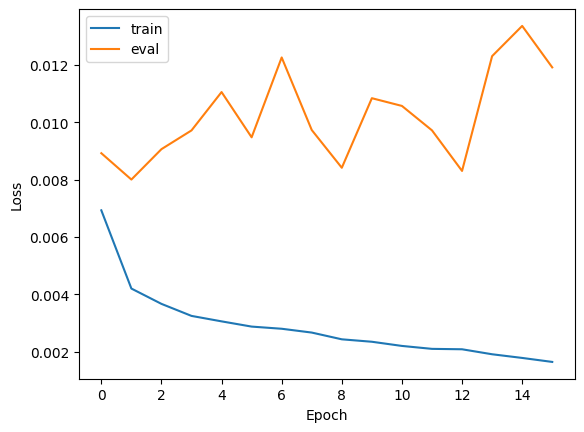

In [81]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_epoch_loss, label='train')
plt.plot(range(epochs), eval_epoch_loss, label='eval')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
eval_loss, eval_acc = evaluate_model(network2, criterion, eval_dataloader, device)
print(f"Accuracy on Eval Data {eval_acc}")

Accuracy on Eval Data 0.6622641509433962


In [83]:
# save model
filename = "Cnn_model.pickle"

if prev_eval_acc > now_eval_acc:
  print("1")
  # pickle.dump(prev_model, open(filename, "wb"))
  torch.save(prev_model.state_dict(), 'Cnn_model.pth')
else:
  # pickle.dump(network2, open(filename, "wb"))
  torch.save(network2.state_dict(), 'Cnn_model.pth')

1


In [84]:
import json

torch.save(network2.state_dict(), 'Cnn_model.pth')
# Assuming best_params is defined
with open('Cnn_best_params.json', 'w') as f:
    json.dump(best_params, f)

In [85]:
with open('bert_vectors_test_'+model_name+'.pkl', 'rb') as f:
    encode_test_vectors, test_labels = pickle.load(f)
test_dataset = CustomDataset(encode_test_vectors, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [86]:
from sklearn.metrics import accuracy_score, classification_report

In [87]:
def get_classification_report(model, test_dataloader, device, model_file = "Cnn"):
    model.eval().to(device)
    y_true = []
    y_pred = []
    with torch.no_grad():
        for test_x, test_y in test_dataloader:
            test_x, test_y = test_x.to(device), test_y.to(device)

            if model_file == "Cnn":
                outputs = model(test_x)
            else:
                outputs = model(test_x)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(test_y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    print(f"{model_file} Accuracy: {accuracy:.4f}")

    # Calculate and print precision, recall, and f1-score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"{model_file} Precision: {precision:.4f}")
    print(f"{model_file} Recall: {recall:.4f}")
    print(f"{model_file} F1-Score: {f1:.4f}")

    # Print the classification report
    print(f"{model_file} Classification Report:")
    print(classification_report(y_true, y_pred))
    print("\n")

In [88]:
with open('Cnn_best_params.json', 'r') as f:
    best_params = json.load(f)

In [90]:
best_model = ConvolutionalNeuralNetwork0(input_dim_x)
best_model2 = ConvolutionalNeuralNetwork2(input_dim = input_dim_x, in_channels=1, output_dim=2, n_layers=best_params['n_layers'],
                        n_units=best_params['n_units'], dropout_prob=best_params['dropout_prob'], activation=activation,
                        optimizer_name=best_params['optimizer'],weight_init_method=best_params['weight_init_method'],
                        learning_rate = best_params['learning_rate'],cnn_kernel = cnn_kernel,
                        cnn_stride = best_params['cnn_stride'], cnn_padding = best_params['cnn_padding'],
                        cnn_channel = best_params['cnn_channel'])
try:
    best_model.load_state_dict(torch.load('Cnn_model.pth', map_location=torch.device(device)))
    get_classification_report(best_model, test_dataloader, device,"Cnn")
except:
    best_model2.load_state_dict(torch.load('Cnn_model.pth', map_location=torch.device(device)))
    get_classification_report(best_model2, test_dataloader, device,"Cnn")
    best_model = best_model2

Cnn Accuracy: 0.6491
Cnn Precision: 0.7995
Cnn Recall: 0.6491
Cnn F1-Score: 0.6106
Cnn Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       496
           1       1.00      0.34      0.51       564

    accuracy                           0.65      1060
   macro avg       0.79      0.67      0.62      1060
weighted avg       0.80      0.65      0.61      1060



